<a href="https://colab.research.google.com/github/Athaaaaa/Customer-Segmentation-with-K-Means-Clustering/blob/main/Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, silhouette_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 读取数据集
df = pd.read_csv('processed_data.csv')
print("原始数据预览：")
print(df.head())

pca = PCA(n_components=5)  # 5个
df_pca = pca.fit_transform(df)

原始数据预览：
       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.636364    1499.00           1499.00   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2        

Explained variance ratio: [0.47540341 0.1776897  0.1400484  0.11349302 0.04809598]
Cumulative explained variance: [0.47540341 0.65309311 0.79314151 0.90663453 0.95473051]


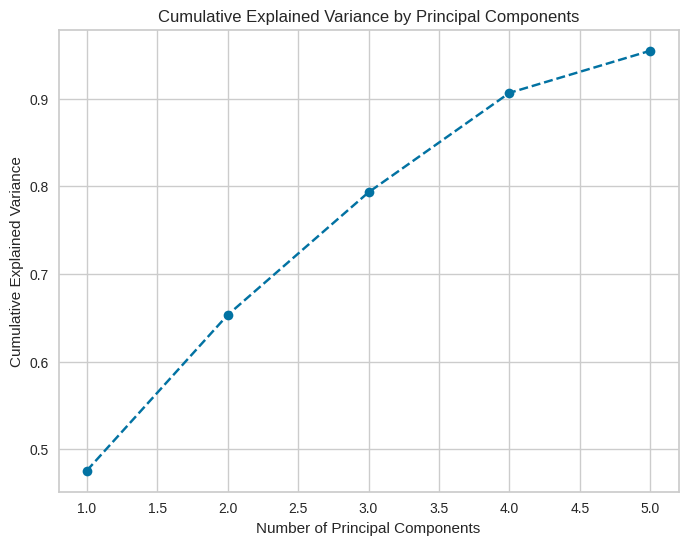


降维后的数据预览：
   Principal Component 1  Principal Component 2  Principal Component 3  \
0           -4324.351008             915.734333             201.122729   
1            4120.975546           -2437.938847            2361.236482   
2            1498.994555           -2001.750670           -2109.071892   
3            1321.563972           -1387.728898           -2765.268751   
4           -3741.083696             751.701480             529.244726   

   Principal Component 4  Principal Component 5  
0            -152.782832             -56.070543  
1           -3923.450851             -52.137671  
2            1052.164413             303.906631  
3            1263.158294             481.252569  
4            -227.577068             227.498468  


In [3]:
# 输出每个主成分的解释方差比例
print("Explained variance ratio:", pca.explained_variance_ratio_)

# 累计解释的方差比例
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance:", cumulative_variance)

# 绘制解释方差的累计曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# 创建一个新的DataFrame存储PCA结果
df_pca_df = pd.DataFrame(data=df_pca, columns=[f'Principal Component {i+1}' for i in range(5)])
print("\n降维后的数据预览：")
print(df_pca_df.head())

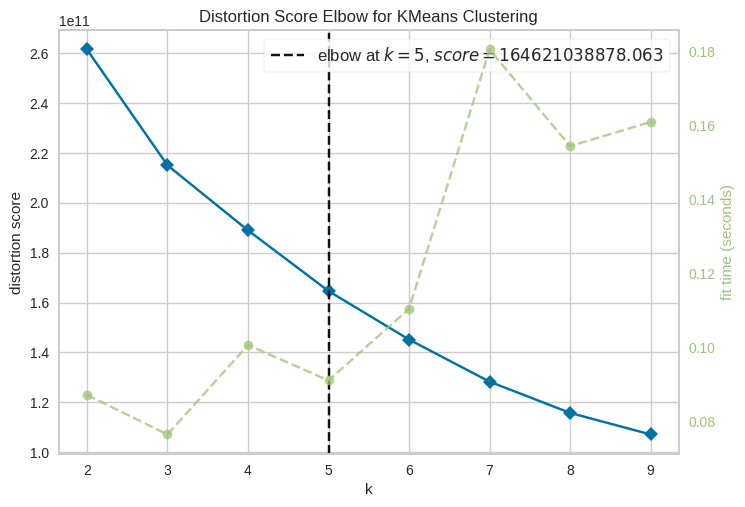


最佳聚类数：5

聚类结果预览：
   Principal Component 1  Principal Component 2  Principal Component 3  \
0           -4324.351008             915.734333             201.122729   
1            4120.975546           -2437.938847            2361.236482   
2            1498.994555           -2001.750670           -2109.071892   
3            1321.563972           -1387.728898           -2765.268751   
4           -3741.083696             751.701480             529.244726   

   Principal Component 4  Principal Component 5  Cluster  
0            -152.782832             -56.070543        4  
1           -3923.450851             -52.137671        2  
2            1052.164413             303.906631        1  
3            1263.158294             481.252569        1  
4            -227.577068             227.498468        4  

聚类结果已保存为 'clustered_pca_data.csv'

带有聚类列的数据预览：
       BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  

In [4]:
# 设置 KMeans 参数
kmeans_params = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 1,
    "tol": 1e-4,
    "algorithm": "lloyd",
    "verbose": 0
}

# 初始化 KMeans 模型
kmeans_model = KMeans(**kmeans_params)

# 使用肘部法则确定最佳聚类数
elbow_visualizer = KElbowVisualizer(kmeans_model, k=(2, 10), metric='distortion', timings=True)
elbow_visualizer.fit(df_pca_df)
elbow_visualizer.show()

# 获取肘部法则确定的最佳聚类数
optimal_clusters = elbow_visualizer.elbow_value_
print(f"\n最佳聚类数：{optimal_clusters}")

# 使用最佳聚类数重新拟合 KMeans 模型
final_kmeans = KMeans(n_clusters=optimal_clusters, **kmeans_params)
df_pca_df['Cluster'] = final_kmeans.fit_predict(df_pca_df)

print("\n聚类结果预览：")
print(df_pca_df.head())

# 从数据集中分离出聚类标签
cluster_labels = df_pca_df['Cluster']

# 移除'Cluster'列，以便用于轮廓系数的计算
df_pca_df_without_cluster = df_pca_df.drop('Cluster', axis=1)

# 保存聚类结果
df_pca_df.to_csv('clustered_pca_data.csv', index=False)
print("\n聚类结果已保存为 'clustered_pca_data.csv'")

# 将聚类结果添加到原始数据框
kmeans_clustered_df = pd.concat([df, pd.DataFrame(final_kmeans.labels_, columns=['K-means Cluster'])], axis=1)
print("\n带有聚类列的数据预览：")
print(kmeans_clustered_df.head())

Silhouette Score: 0.3931
Calinski-Harabasz Score: 2862.2336


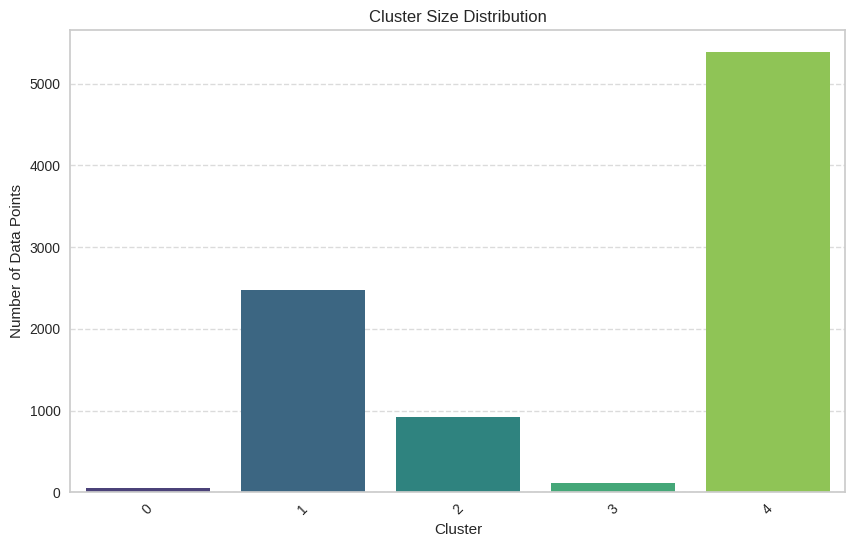

In [5]:
# 计算轮廓系数（Silhouette Score）
silhouette_avg = silhouette_score(df_pca_df.drop('Cluster', axis=1), df_pca_df['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.4f}")  # 输出轮廓系数

# 计算Calinski-Harabasz分数
calinski_harabasz = calinski_harabasz_score(df_pca_df.drop('Cluster', axis=1), df_pca_df['Cluster'])
print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")  # 输出Calinski-Harabasz分数

# 可视化簇的分布
cluster_counts = df_pca_df['Cluster'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
# 特征重要性分析
X = kmeans_clustered_df.drop('K-means Cluster', axis=1)
y = kmeans_clustered_df['K-means Cluster']
print('X:', X.shape, '\ny:', y.shape)

X: (8949, 17) 
y: (8949,)


In [7]:
# 测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# 不同的模型
models = [
    ('Random Forest', RandomForestClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# 预测
results = pd.DataFrame(index=['Accuracy Score'])
y_preds = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)
    results[name] = [accuracy_score(y_test, y_pred)]


X_train shape: (7159, 17)
X_test shape: (1790, 17)
y_train shape: (7159,)
y_test shape: (1790,)


In [8]:
# 找到最好的模型
best_score = results.max(axis=1).iloc[0]
best_col = results.idxmax(axis=1).iloc[0]

print("\nModel Performance:")
print(results)

classifiers = [RandomForestClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()]
for clf in classifiers:
    clf.fit(X_train, y_train)

importances = [clf.feature_importances_ for clf in classifiers]
common_features = []

for i, importance in enumerate(importances):
    idx = np.argsort(importance)[::-1]
    significant_features = X_train.columns[importance[idx] >= 0.05]
    common_features.extend(significant_features)

common_features_count = Counter(common_features)
common_features_table = pd.DataFrame.from_dict(common_features_count, orient='index', columns=['Count'])
common_features_table.index.name = 'Feature'
common_features_table.sort_values(by='Count', ascending=False, inplace=True)


Model Performance:
                Random Forest  Decision Tree  AdaBoost  Gradient Boosting
Accuracy Score        0.97486       0.964246  0.889385           0.982123


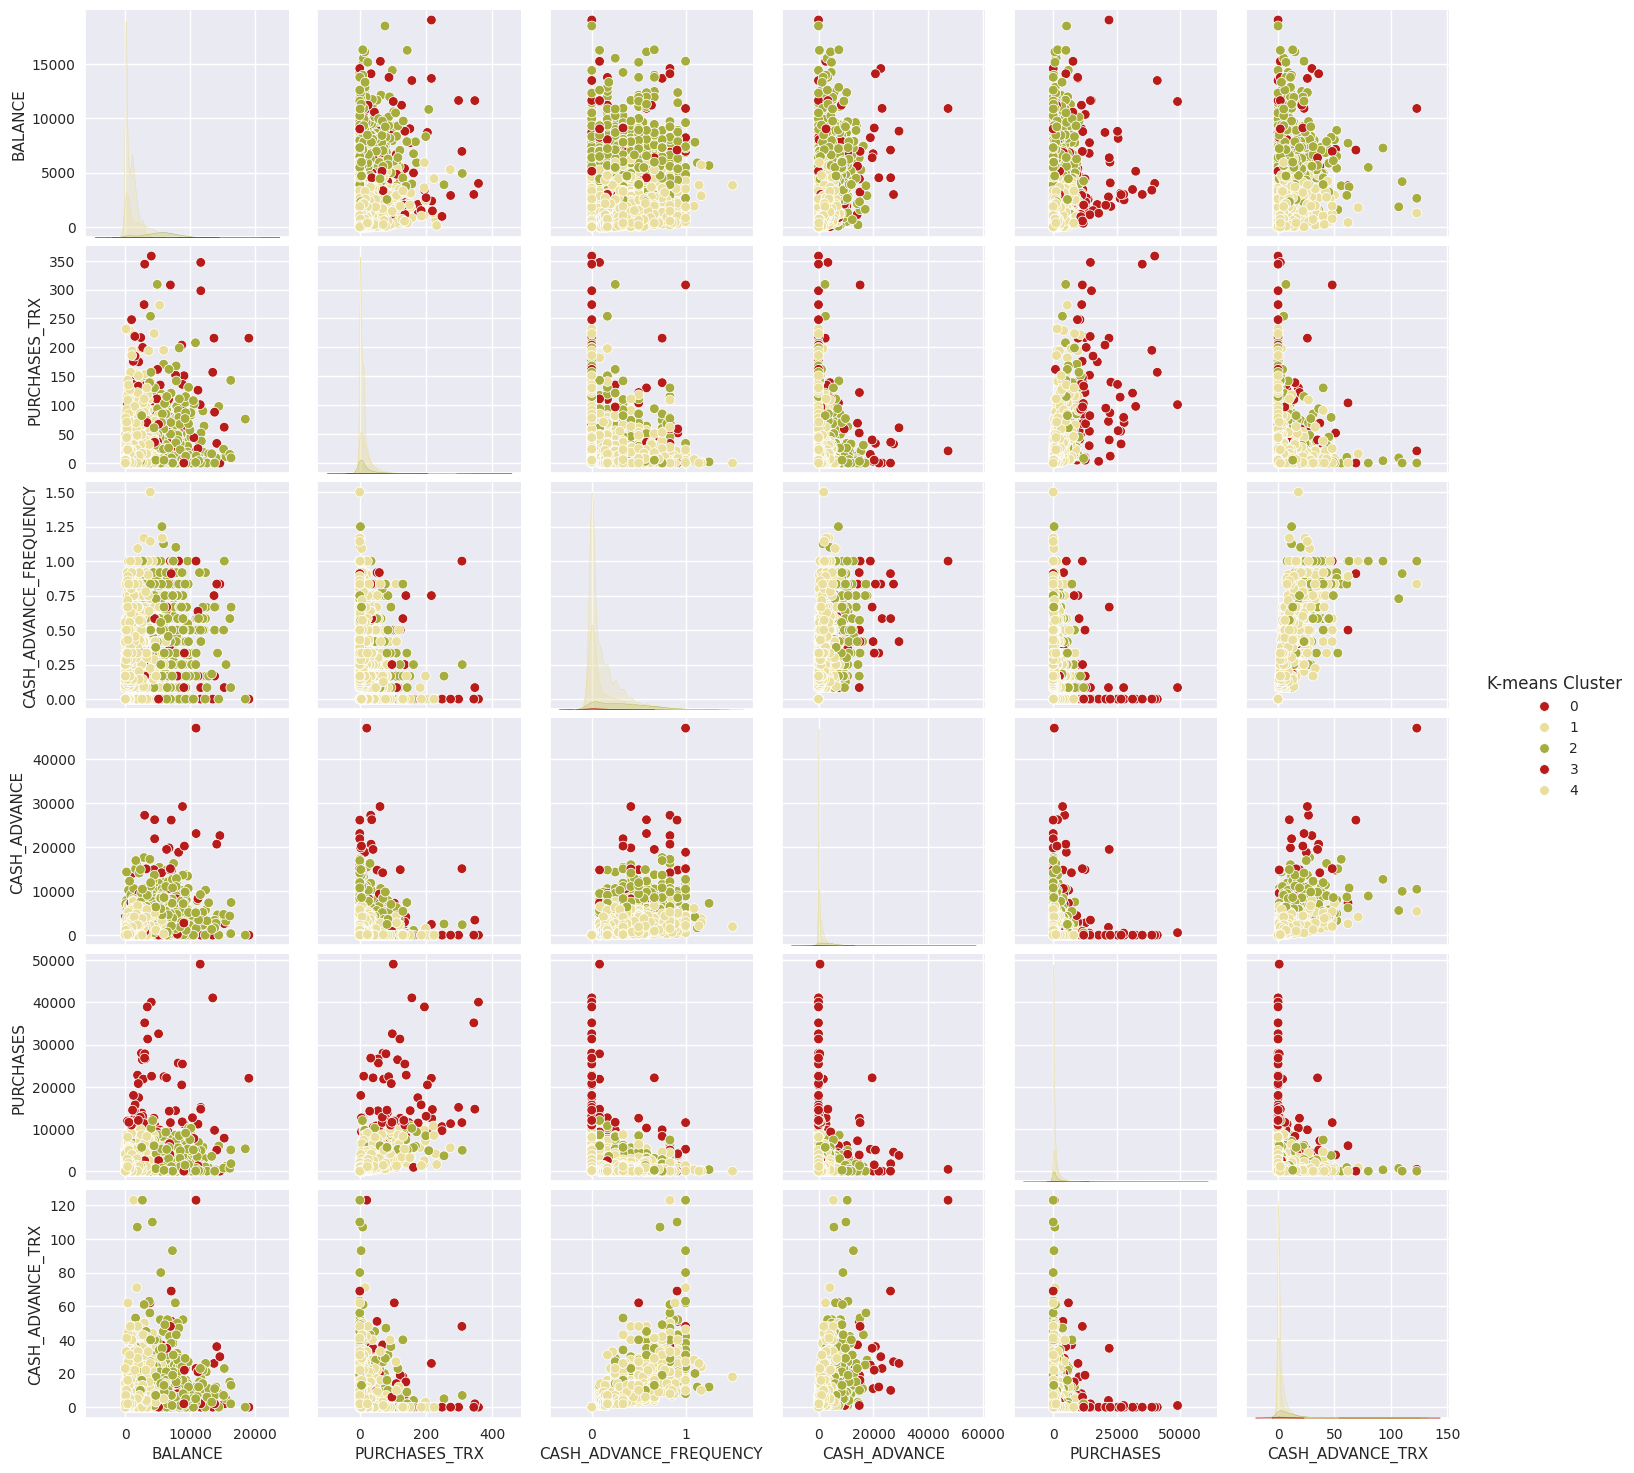

In [9]:
# 聚类分析与客户细分
important_variables = ['BALANCE', 'PURCHASES_TRX', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE', 'PURCHASES', 'CASH_ADVANCE_TRX', 'K-means Cluster']

sns.set_style('darkgrid')
sns.pairplot(kmeans_clustered_df[important_variables], hue='K-means Cluster', palette=["#B71C1B", '#e9de9c', "#A6AD3C"])
plt.show()

,K-means Cluster,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0,4058.147688,0.988636,1027.378750,118.389464,908.989286,922.757849,0.471320,0.039232,0.441153,0.105655,3.017857,18.625000,4267.857143,1624.939144,22760.031552,0.001488,11.910714
1,1,1634.098154,0.906097,1444.263728,896.579742,548.093366,811.274131,0.579666,0.327097,0.402188,0.115558,2.710198,20.721483,6773.137054,2008.686927,636.069954,0.196063,11.760580
2,2,5390.175744,0.956552,1532.468120,952.321377,580.219913,3812.695118,0.473919,0.271572,0.348401,0.325873,9.544262,21.474317,10936.343766,3939.217438,1863.889356,0.071634,11.663388
3,3,4775.623010,0.907657,11730.387946,8394.386339,3336.198036,5156.438056,0.766153,0.622973,0.610440,0.205019,8.767857,88.991071,12665.178571,19012.514772,2435.463080,0.356370,11.857143
4,4,789.915865,0.848860,486.893214,233.932217,253.254778,488.417261,0.446546,0.126279,0.343923,0.110607,2.315320,9.207799,2182.436501,873.406494,507.159351,0.145547,11.370288


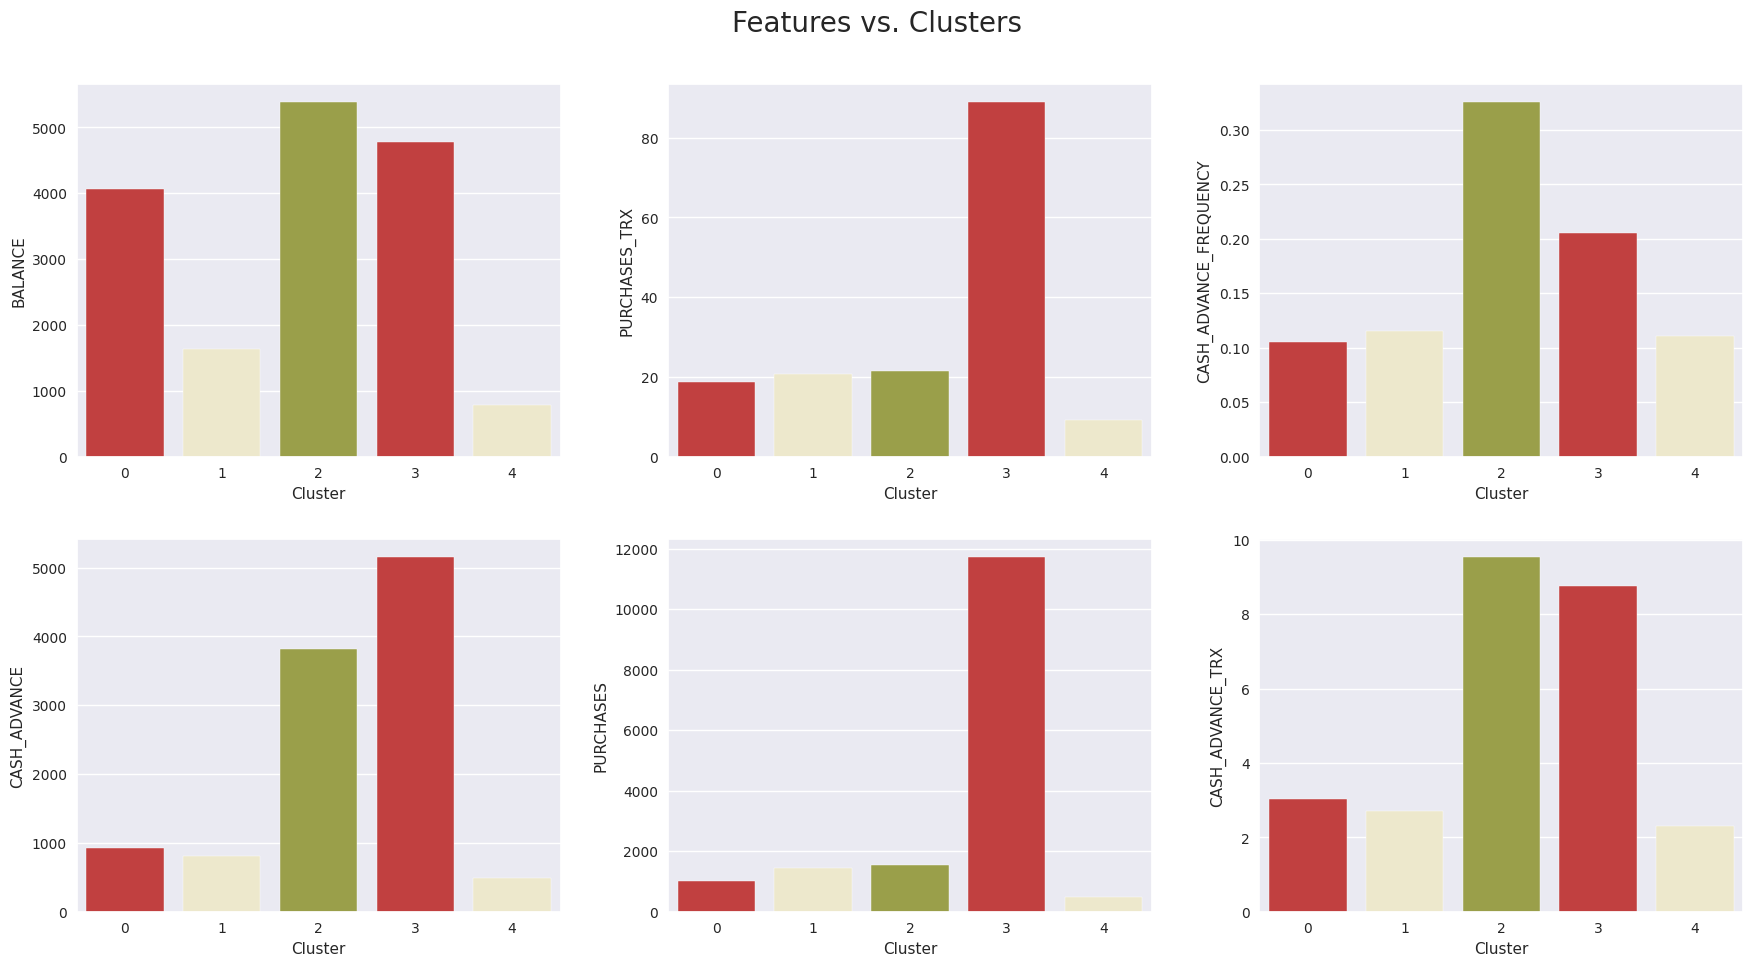

In [10]:
# 总结每个特征的平均值
avg_df = kmeans_clustered_df.groupby(['K-means Cluster'], as_index=False).mean()
display(avg_df.style.background_gradient(cmap="coolwarm"))

custom_colors = ["#D72A2B", "#F2ECC6", "#A6AD3C"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
for i, col in enumerate(['BALANCE', 'PURCHASES_TRX', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE', 'PURCHASES', 'CASH_ADVANCE_TRX']):
    sns.barplot(x='K-means Cluster', y=col, data=avg_df, ax=axes[i//3][i%3], palette=custom_colors)
    axes[i//3][i%3].set_xlabel('Cluster')
    axes[i//3][i%3].set_ylabel(col)
plt.suptitle('Features vs. Clusters', fontsize=20)
fig.tight_layout(pad=2.0)
plt.show()

cmap = 'coolwarm'
db_g = pd.DataFrame(kmeans_clustered_df.groupby(['K-means Cluster','TENURE'])['TENURE'].count())
db_g.T.style.background_gradient(cmap=cmap).set_properties(**{'font-family': 'Segoe UI'})